<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 1</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

Execute the following cell for a `pandas` DataFrame of Australian interest rate data on 11 August 2023:

In [213]:
import pandas as pd

df = pd.DataFrame(
    [
        {"Type": "BBSW", "Term": "1 month", "Rate": 4.06},
        {"Type": "BBSW", "Term": "3 months", "Rate": 4.17},
        {"Type": "BBSW", "Term": "6 months", "Rate": 4.50},
        {"Type": "Swap", "Term": "1 year", "Rate": 4.29},
        {"Type": "Swap", "Term": "3 years", "Rate": 4.06},
        {"Type": "Swap", "Term": "5 years", "Rate": 4.20},
        {"Type": "Swap", "Term": "10 years", "Rate": 4.45},
        {"Type": "Swap", "Term": "15 years", "Rate": 4.58},
    ]
)
df

,Type,Term,Rate
0,BBSW,1 month,4.06
1,BBSW,3 months,4.17
2,BBSW,6 months,4.50
3,Swap,1 year,4.29
4,Swap,3 years,4.06
5,Swap,5 years,4.20
6,Swap,10 years,4.45
7,Swap,15 years,4.58


Note that the bank bill swap rate (BBSW) is quoted per annum with simple compounding, and "Swaps are quoted on a quarterly basis for maturities out to 3 years and on a semi-annual basis for maturities 4 years and greater." AFMA (2023), Interest Rate Derivative Conventions (see https://afma.com.au/getattachment/Standards/Market-Conventions/Sections/Content/Interest-Rate-Derivative-Conventions-2023-07.pdf?lang=en-AU )

<H2>Task 1:</H2>
Determine the term structure of zero coupon bond prices that these rates imply, using loglinear interpolation where necessary. <I>(4 marks)</I>

In [214]:
import numpy as np  # 1.26.4
import scipy as sp  # 1.14.1
import matplotlib.pyplot as plt  # 3.9.2

We suppose that the term structure we are looking for is discrete, giving the ZCB prices for maturities 1m, 3m, 6m, then every 3m between 9m and 3y, then every 6m between 3y and 15y. We start by using BBSW rates to find the 1m, 3m, 6m maturities and then we use the swap yields and loglinear interpolation to find the quarterly maturities ZCB prices up to 15y.

In [215]:
# Finding the 1m, 3m, 6m maturities
df["Maturity"] = df["Term"].str[0].astype(np.int16)
df_bbsw = df[df["Type"] == "BBSW"].reset_index(drop=True)
df_swap = df[df["Type"] == "Swap"].reset_index(drop=True)

# Result Vector
ZCBs = []

for row in df_bbsw.iterrows():
    mat = row[1].iloc[3] / 12
    rate = row[1].iloc[2] / 100
    ZCBs.append((1 + (mat) * rate) ** (-1))

ZCBs

[0.9966280750128732, 0.9896825593190985, 0.9779951100244499]

The two equations we need to find the ZCB prices using the swap are :

$$(1 - B(T_1,T_n)) = \ell (T_1, \mathbb{T}) \sum_{i=2}^{n} (T_i - T_{i-1})B(T_1, T_i)\tag{1}$$

$$\ln{B(t,T_i)} = \ln{B(t,T_1)} + \frac{T_i-T_1}{T_2-T_1}\ln(\frac{B(t,T_2)}{B(t,T_1)}) \tag{2}$$

We will proceed by intervals between available swap rates maturities.

In [216]:
# 9m and 1Y maturities
l = df_swap.iloc[0, 2] / 100


def f(x):
    a = ZCBs[1]
    b = ZCBs[2]
    res1 = (l / 4) * (a + b + x[0] + x[1]) - 1 + x[1]
    res2 = np.log(b) + (1 / 2) * np.log(x[1] / b) - np.log(x[0])
    return [res1, res2]


result = sp.optimize.fsolve(f, [1, 1])
ZCBs.append(result[0])
ZCBs.append(result[1])

ZCBs

[0.9966280750128732,
 0.9896825593190985,
 0.9779951100244499,
 0.9680656790940592,
 0.9582370601182385]

In [217]:
# Generic function to interpolate between two swap maturities using fsolve
def interp(x, ZCBs, l, freq):
    # We have n2 unknown
    n1 = len(ZCBs)
    n2 = len(x)

    result = []

    # First equation using the swap yield identity
    temp = 1 - x[-1]
    for i in range(n1):
        temp = temp - (l / freq) * ZCBs[i]
    for i in range(n2):
        temp = temp - (l / freq) * x[i]

    result.append(temp)

    # n2 - 1 remaining equations using loglinear interpolation
    for i in range(n2 - 1):
        result.append(
            np.log(ZCBs[-1]) + ((i + 1) / n2) * np.log(x[-1] / ZCBs[-1]) - np.log(x[i])
        )

    return result


def interpolate_between(zcbs):
    result = [zcbs[0]]
    for i in range(len(zcbs) - 1):
        temp = np.exp(np.log(zcbs[i]) + 0.5 * np.log(zcbs[i + 1] / zcbs[i]))
        result.append(temp)
        result.append(zcbs[i + 1])
    return result[1:]

In [218]:
# From 1Y to 3Y
l1 = list(
    sp.optimize.fsolve(interp, [0.9] * 8, (ZCBs[1:], df_swap.iloc[1, 2] / 100, 4))
)
ZCBs = ZCBs + l1

l1

[0.9488953422690587,
 0.9396446957526028,
 0.9304842321848268,
 0.9214130727795125,
 0.9124303468821778,
 0.9035351922857662,
 0.8947267552945117,
 0.8860041904994865]

In [219]:
# From 3Y to 5Y
temp_ZCBs = ZCBs[2::2]
l2 = list(
    sp.optimize.fsolve(interp, [0.9] * 4, (temp_ZCBs, df_swap.iloc[2, 2] / 100, 2))
)
ZCBs = ZCBs + l2

l2

[0.8669392272917921, 0.848284502404901, 0.8300311882279903, 0.8121706473779828]

In [220]:
# From 5Y to 10Y
l3 = list(
    sp.optimize.fsolve(
        interp, [0.8] * 10, (temp_ZCBs + l2, df_swap.iloc[3, 2] / 100, 2)
    )
)
ZCBs = ZCBs + l3

l3

[0.7932800684719228,
 0.7748288725630121,
 0.7568068398851961,
 0.7392039883509625,
 0.7220105680396531,
 0.7052170558877149,
 0.6888141504024506,
 0.6727927662350047,
 0.6571440289699444,
 0.6418592719306422]

In [221]:
# From 10Y to 15Y
l4 = list(
    sp.optimize.fsolve(
        interp, [0.6] * 10, (temp_ZCBs + l2 + l3, df_swap.iloc[4, 2] / 100, 2)
    )
)
ZCBs = ZCBs + l4

l4

[0.6263507328556114,
 0.6112169095012647,
 0.5964487480740318,
 0.5820374134763482,
 0.5679742841397424,
 0.554250946719517,
 0.5408591909775663,
 0.527791005470973,
 0.5150385730627179,
 0.502594262478548]

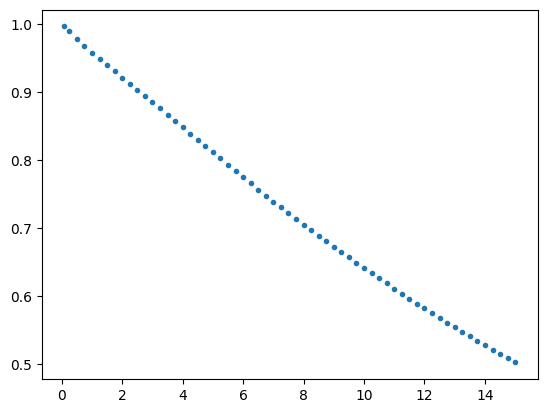

In [222]:
# interpolating every 3m from 3Y to 15Y
maturities = [1 / 12] + [0.25 * (i + 1) for i in range(60)]
temp = interpolate_between(ZCBs[12:])
ZCBs = ZCBs[:13] + temp

plt.plot(maturities, ZCBs, ".")
plt.show()

<H2>Task 2:</H2>
Find the coefficients of a "maximum smoothness" term structure (as defined on Slides 34 to 36 of Lecture 1b) fitting the BBSW and swap rates given above. <I>(10 marks)</I>

In [223]:
# x is the time we want to find the forward rate at, c, b, a are splines coefficients vectors
# t is the vector of maturities giving the times when splines change
def f(x, c, b, a, t):
    if x == 0:
        return a[0]
    if (x > t[-1]) or (x < 0):
        return 0
    for i in range(len(t) - 1):
        if (x > t[i]) and (x <= t[i + 1]):
            return a[i] + (b[i] * x) + (c[i] * (x**4))

In [224]:
# Find the discount factor maturing at T=x using the c, b, a coeeficients vectors
# t is the vector of maturities giving the times when splines change
def integrate_ZCB(x, c, b, a, t):
    result = 0
    if x <= 0:
        return result
    for i in range(len(t) - 1):
        if (x > t[i]) and (x <= t[i + 1]):
            result = (
                result
                + ((a[i] * x) + (0.5 * b[i] * (x**2)) + (0.2 * c[i] * (x**5)))
                - (
                    (a[i] * t[i])
                    + (0.5 * b[i] * (t[i] ** 2))
                    + (0.2 * c[i] * (t[i] ** 5))
                )
            )
            break
        else:
            result = (
                result
                + (
                    (a[i] * t[i + 1])
                    + (0.5 * b[i] * (t[i + 1] ** 2))
                    + (0.2 * c[i] * (t[i + 1] ** 5))
                )
                - (
                    (a[i] * t[i])
                    + (0.5 * b[i] * (t[i] ** 2))
                    + (0.2 * c[i] * (t[i] ** 5))
                )
            )

    return result

In [225]:
# This function takes three parameters:
# t : the vector of available maturities in the market
# ZCBs : the vector of the ZCB prices corresponding to the n=len(ZCBs) first maturities
# swaps : the vector of swap rates corresponding to the m-n=len(swaps) remaining maturities
def spline_4th_order(t, ZCBs, swaps):

    # Checking that the number of maturities match
    if len(t) != (len(ZCBs) + len(swaps)):
        raise ValueError(
            "Sum of length of arrays ZCBs and swaps must match length of array t"
        )

    n = len(ZCBs)
    m = len(t)

    # This is the function we are going to use fsolve on to find all the coefficients of the splines
    def tointerp(x, ZCBs, t, swaps):
        # Separating the coefficients in vectors named using the convention on page 34 of lecture 1b
        c = x[0:m]
        b = x[m : 2 * m]
        a = x[2 * m :]

        result = []

        # region easy conditions

        for i in range(m - 1):
            result.append(
                (c[i] * (t[i + 1] ** 4))
                + (b[i] * t[i + 1])
                + a[i]
                - (c[i + 1] * (t[i + 1] ** 4))
                - (b[i + 1] * t[i + 1])
                - a[i + 1]
            )
            result.append(
                (4 * c[i] * (t[i + 1] ** 3))
                + b[i]
                - (4 * c[i + 1] * (t[i + 1] ** 3))
                - b[i + 1]
            )
            if i < n:

                result.append(
                    (0.2 * c[i] * ((t[i + 1] ** 5) - (t[i] ** 5)))
                    + (0.5 * b[i] * ((t[i + 1] ** 2) - (t[i] ** 2)))
                    + (a[i] * (t[i + 1] - t[i]))
                    + np.log(ZCBs[i + 1] / ZCBs[i])
                )

        result.append(b[-1])
        result.append(a[0] - df_bbsw["Rate"].iloc[0] / 100)

        # endregion

        # region remaining m-n conditions using the fixed point

        # frequencies is used to store maturities of discount factors every 3m
        frequencies = np.cumsum([0] + [0.25] * (4 * t[-1]))

        temp_maturities = t[len(ZCBs) :]  # swap maturities)
        temp_freq = [4, 4, 2, 2, 2]  # swaps quotation

        # We definde our fixed point function based on the formula on page 37 of lecture 1b
        def fixed_point(x, swap, partial_sum, freq):
            return 1 - ((swap * x) + (partial_sum * swap)) / freq

        temp = []

        # We solve the fixed point problem for each swap yield and store the solution in the vector temp
        for i in range(len(temp_maturities)):
            swap = swaps[i] / 100
            # maturities of ZCBs for each swap cashflows
            temp_list = frequencies[
                : temp_maturities[i] * 4 + 1 : int(3 - (temp_freq[i] / 2))
            ][1:-1]
            # Sum of ZCBs
            partial_sum = sum(
                [
                    np.exp(-integrate_ZCB(frequency, c, b, a, t))
                    for frequency in temp_list
                ]
            )
            # the expression int(3 - (temp_freq[i] / 2)) maps 1 to 4 and 2 to 2 to give the correct step
            x = sp.optimize.fixed_point(
                fixed_point, [1], (swap, partial_sum, temp_freq[i])
            )[0]
            temp.append(x)

        # We then compare this result with the integration using the splines and add this condition to result
        for i in range(n, m):
            result.append(integrate_ZCB(t[i + 1], c, b, a, t) + np.log(temp[i - n]))

        # endregion

        return result

    # region solving the equations

    # Using fsolve to find the coefficients of the spline
    interpolation = sp.optimize.fsolve(
        tointerp, [1000] * 3 * m, args=([1] + ZCBs, [0] + t, swaps)
    )

    # Printing the result
    l = int(len(interpolation) / 3)
    print("Splines coefficients : ")
    print("c : ")
    print(interpolation[:l])
    print("b : ")
    print(interpolation[l : 2 * l])
    print("a : ")
    print(interpolation[2 * l : 3 * l])

    # endregion

    # region outputs

    # Defining a function that takes as argument a linspace and returns the linspace truncated to the correct length
    # and the image of our splines mapped to each x of the linspace. This way, we get x and y and can plot the term structure
    def splines(freq):

        c = interpolation[0:m]
        b = interpolation[m : 2 * m]
        a = interpolation[2 * m : 3 * m]

        z = t + [100]
        result = []
        index = 0

        for time in freq:
            try:
                if time < z[index]:
                    result.append((c[index] * time**4) + (b[index] * time) + a[index])
                else:
                    index = index + 1
                    result.append((c[index] * time**4) + (b[index] * time) + a[index])
            except:
                break
        return freq[1 : len(result)], result[1:]

    # f_result gives the price of a ZCB maturing at date x
    def f_result(x):

        c = list(interpolation[0:m])
        b = list(interpolation[m : 2 * m])
        a = list(interpolation[2 * m : 3 * m])

        res = np.exp(-integrate_ZCB(x, c, b, a, [0] + t))

        return res

    # endregion

    return splines, f_result

Splines coefficients : 
c : 
[ 5.42405730e+00  5.78832452e-01 -1.82579929e-01  1.06705469e-02
  4.91791559e-06 -3.77364145e-06 -2.46494686e-07  3.25664496e-08]
b : 
[-2.90022026e-03  8.31557799e-03  5.59038518e-02 -4.07213862e-02
  1.94112976e-03  2.87981793e-03  1.11624454e-03  4.73799799e-27]
a : 
[0.0406     0.03989901 0.03097621 0.06721068 0.03521379 0.03310174
 0.03971514 0.04808697]


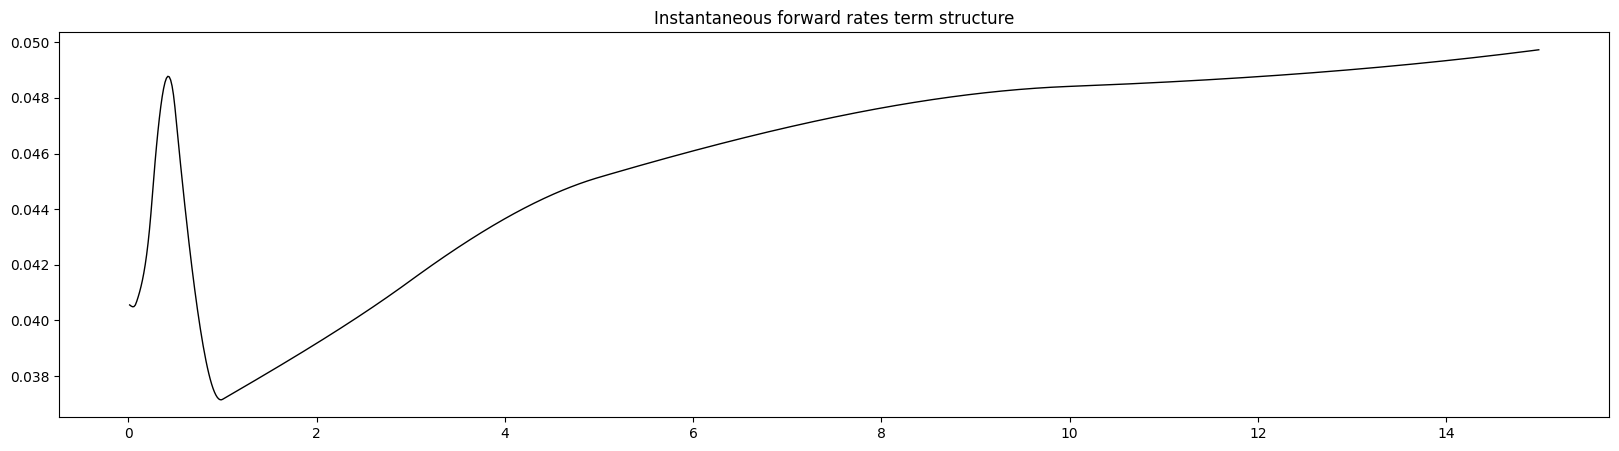

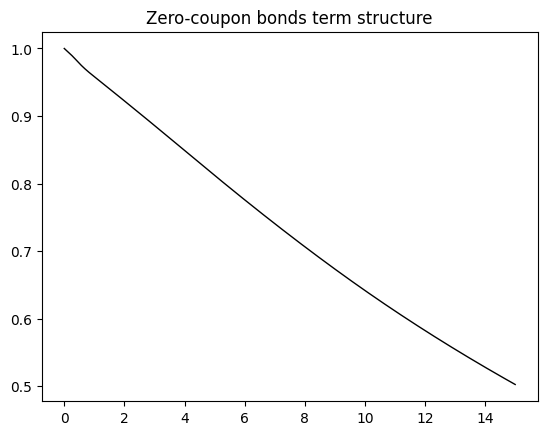

In [226]:
# Variables
T = [1 / 12, 1 / 4, 1 / 2, 1, 3, 5, 10, 15]
BBSW_ZCBs = ZCBs[0:3]
swap = list(df_swap["Rate"])

# Functions of the forward curve and of the bond price for a given maturity
forward_curve, ZCB_curve = spline_4th_order(T, BBSW_ZCBs, swap)

xs, ys = forward_curve(np.linspace(0, 15, 1000))
xss = np.linspace(0, 15, 1000)
yss = [ZCB_curve(x) for x in xss]

plt.figure(figsize=(20, 5))
plt.plot(xs, ys, lw=1, color="black")
plt.title("Instantaneous forward rates term structure")
plt.show()
plt.plot(xss, yss, lw=1, color="black")
plt.title("Zero-coupon bonds term structure")
plt.show()

<H2>Task 3:</H2>
Consider a coupon bond with a principal of 100 and a coupon rate of 8% per annum, where the bond matures in exactly five years and the coupons are paid quarterly. Using the term structure that you derived in Task 1, what is the value of this bond? Similarly, using the term structure that you derived in Task 2, what is the value of this bond? <I>(1 mark)</I>

In [227]:
cashflows = [2] * 19 + [102]
payment_dates = [0.25 * (i + 1) for i in range(20)]

ZCBs_Q1 = ZCBs[1:21]

result_Task_1 = sum([cashflows[i] * ZCBs_Q1[i] for i in range(20)])

result_Task_2 = sum([cashflows[i] * ZCB_curve(payment_dates[i]) for i in range(20)])

print(f"Value using Task 1 : ${round(result_Task_1, 2)} ({result_Task_1})")
print(f"Value using Task 2 : ${round(result_Task_2, 2)} ({result_Task_2})")

Value using Task 1 : $117.18 (117.1824274974974)
Value using Task 2 : $117.19 (117.18980599957736)
